Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 07: EEG simulation & filtering in 2-D

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, June 18, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this sheet we are going dig deeper into signal processing. Specifically, we will learn how the basic concepts in signal processing expand to 2-D space. You will need to have understandings of what fourier transform and inverse transform do and what kind of effect convolution has.

 Let's say your friend wants to send you a deep picture per messaging app. But he is too afraid that the server might get hacked. Therefore he decides to add some noise in his picture and just sends you the 2d shaped text file of the image. Now you have to denoise the image to see it. Surely you can use a simple filtering function to achieve this, but that sounds too boring for you. Instead, you want to convolve the filter and the image in a spatial domain.

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import fftpack
from scipy import signal

## Assignment 0: Peer review for sheet 07 [0 pts]

This week there will be no peer-review for obvious reasons.

## Assignment 1: Simulate 4-channel EEG signal [4 pts]

Before starting with the image, we will try to approximate an actual EEG signal as an extension from next week's sheet. Although our later EEG data will be composed of 64 channels, we will stick with 4 for simplicity. 

### a) Generate signal [3 pts]

Write a function that creates the signal for one channel, given a certain frequency-list (4 different frequencies) and the length of the signal. 
Within the function:
- First, define a sampling rate of 1000 Hz and a time-window of 1 second (i.e. 1000 ms)
- Define a list that assigns an amplitude to each element of frequencyList: For this, randomly draw with replacement from a range between 0 and 30 (hint: you need as many amplitude-samples as number of elements in frequencyList, checkout *np.random.choice*)
- Create each signal component with given frequency and amplitude. Add them all up.
- Add a small Gaussian noise to the signal.

In [2]:
def generateSignal(frequencyList, signalLen=1000, noiseLevel=2.0):
    # generate the time interval of length signal length
    t = np.linspace(0, 1, signalLen, endpoint=False)
    # sample random amplitudes between 0 and 30
    amps = np.random.choice(30, len(frequencyList))
    #phis = np.random.randint(1, 24, len(frequencyList))
    #phases = [np.pi/phi for phi in phis]
    # construct len(frequencyList) many signals and store them in fake_eeg
    fake_eeg = []
    for n,f in enumerate(frequencyList):
        sig = amps[n]*np.sin(2*np.pi*f*t) #+ phases[n])
        fake_eeg.append(sig)
    # sum up all sinusoides and add gaussian noise of strength noiseLevel
    signal = sum(fake_eeg) + np.random.normal(0, noiseLevel, 1000)
    return signal

### b) Plot [1 pt]
Once you wrote the function, use it to create 4 differnet signals (which each represent a channel). To make it more realistic, randomly sample frequencies of each signal from a common EEG frequency-band. These 4 common EEG frequency-bands are already given below.
 
Lastly, plot these 4 different signals.

In [3]:
# define frequency-bands typical for EEG data
delta = list(range(0,4))
theta = list(range(4,8))
alpha = list(range(8,14))
beta = list(range(13,31))
frexlist = [delta, theta, alpha, beta]

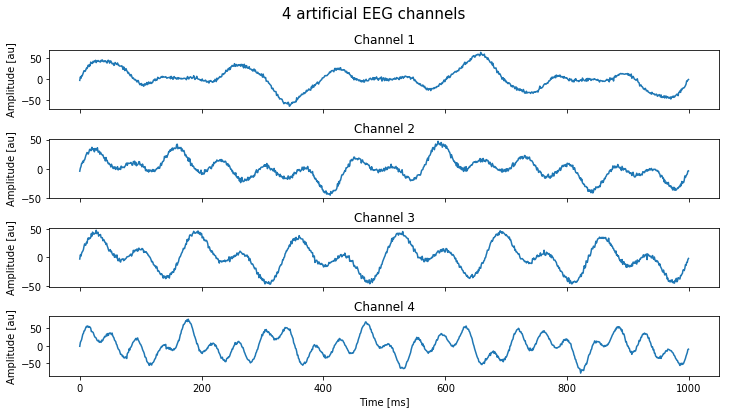

In [4]:
# store the 4 channels in a list to plot power-spectrograms
channel_signal = []
# define the figure and the title
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(12,6))
plt.suptitle('4 artificial EEG channels', fontsize=15)
plt.subplots_adjust(hspace=0.5)
# Plot each graph
for (n, ax) in enumerate(axes):
    # randomly sample from all 4 frequency bands and store frequencies in freqList
    freqList = []
    for band in frexlist:
        freqList.append(np.random.choice(band))
    # generate the signal from the 4 sinusoides
    s = generateSignal(freqList)
    channel_signal.append(s)
    # plot the signal and set axis title and lables
    axes[n].plot(s)
    axes[n].set(title="Channel "+str(n+1), ylabel="Amplitude [au]")
    if n==3:
        axes[n].set_xlabel("Time [ms]")

### BONUS!
### a) Power-Spectogram
compute and plot the nice and colorful power-spectogram of our signals with *plt.specgram*

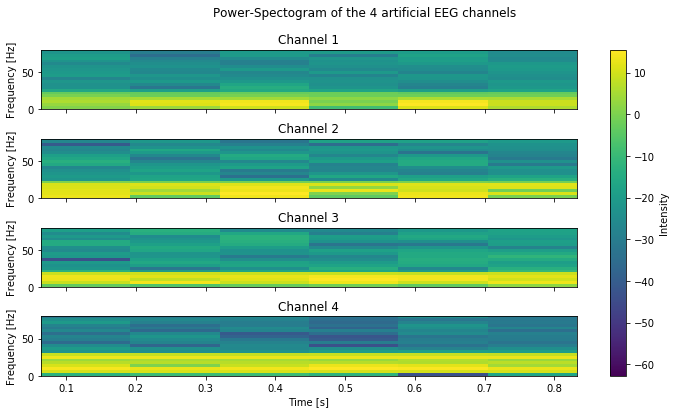

In [5]:
# set figure size, title and details
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(12,6))
plt.suptitle('Power-Spectogram of the 4 artificial EEG channels', fontsize=12)
plt.subplots_adjust(hspace=0.5)
# Plot each graph
for (n, ax) in enumerate(axes):
    axes[n].specgram(channel_signal[n], Fs=1000, NFFT=256)
    axes[n].set(title="Channel "+str(n+1), ylabel="Frequency [Hz]", ylim=(0,80))
    if n == 3:
        axes[n].set_xlabel("Time [s]")
# add a colorbar
mappable = axes[1].images[0]
fig.colorbar(mappable=mappable, ax=axes.ravel().tolist()).set_label('Intensity');

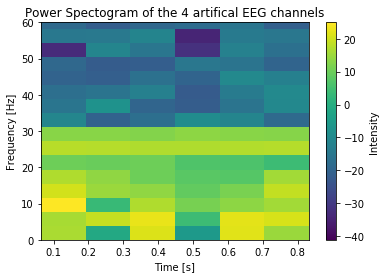

In [6]:
# sum the signals of the 4 channels
overall_signal = sum(s for s in channel_signal)
fig, ax = plt.subplots()
# plot the power-spectrogram of the combined signal
pxx,  freq, t, cax = ax.specgram(overall_signal, Fs=1000, NFFT=256)
# set title and labes and add colorbar
ax.set(title="Power Spectogram of the 4 artifical EEG channels", xlabel="Time [s]",ylabel="Frequency [Hz]", ylim=(0,60))
fig.colorbar(cax).set_label('Intensity');

## Assignment 2: Load the data [1 pts]
Now let's start cracking the puzzle. Because your friend just sent you some text file, you need to load them into an image.
- First load the text file into a numpy array.
- Plot this numpy array. Use a gray colormap.

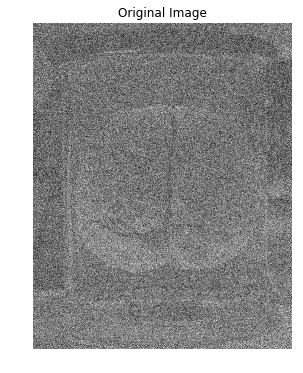

In [7]:
# read the noisy image from the text file
im = np.loadtxt("important.txt", comments="#", delimiter=" ")
# plot the image with gray colormap
plt.figure(figsize=(8,6))
plt.imshow(im, cmap='gray')
# remove axis and add title
plt.axis('off')
plt.title("Original Image");

## Asignment 3: Fourier transform [2 pts]
Do a fourier transform on the image.
- Don't panic. It's just the same concept, only in a 2-D space rather than in a 1-D space. 
- If you use ***numpy.fftpack.fft2***, you should shift the zero-frequency component to be at the center by ***numpy.fftpack.fftshift***.
- You should plot the power spectrum of the fourier transformed image at the end. 
- See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/ for differences between magnitiude, phase and power (amplitude).
- Use log scale in the plot. Check the parameter @norm of ***matplotlib.pyplot.imshow***.

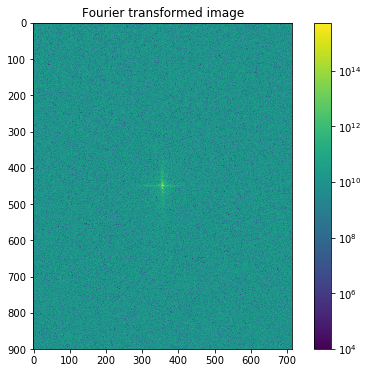

In [8]:
from matplotlib.colors import LogNorm
# transform the signal to fourier space and shift zero component to the center
im_fft = fftpack.fftshift(fftpack.fft2(im))

plt.figure(figsize=(8,6))
# plot the power spectrum of the signal with a log scale
plt.imshow(np.abs(im_fft)**2, norm=LogNorm(vmin=10000))
# add colorbar and title
plt.colorbar()
plt.title('Fourier transformed image');

## Assignment 4: Create low pass filter [2 pts]
To filter the image, you need a filter. We are going to use a low pass filter (2-D Gaussian). 
- Your distribution should be rotationally symmetric for every angle.
- The filter should have 120 x 120 size, and the standard deviation should be 3.
- In our case it's easy to go from 1-D Gaussian distribution to 2-D Gaussian distribution, because there are no interaction between two dimensions (covariance matrix would be diagonal).
- Plot your filter.

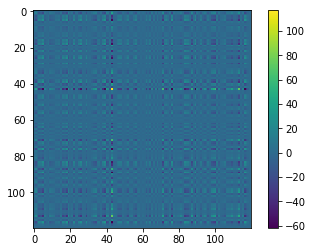

In [66]:
# define a 2-D Gaussian as a combination of 2 1-D Gaussians
def gauss_2d(mu, sigma):
    x = random.gauss(mu, sigma)
    y = random.gauss(mu, sigma)
    return (x, y)
filter_x =[]
filter_y =[]
for i in range(120):
    x, y = gauss_2d(0, 3)
    filter_x.append(x)
    filter_y.append(y)
# draw from a single gaussian and do outer product to get a shitty kernel
values = []
for i in range(120):
    x = random.gauss(0, 3)
    values.append(x)
k = np.outer(values,values)
plt.imshow(k)
plt.colorbar();

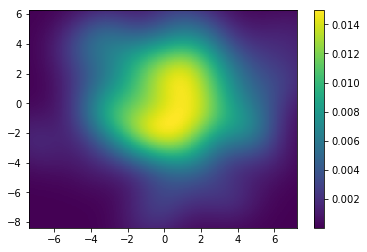

In [50]:
from scipy.stats import kde
# get a 2-D Gaussian from the multivariate normal
# what exactly does size 120*120 mean??
x,y=np.random.multivariate_normal([0,0], [[9,0],[0,9]], 120).T
# set bins for the density plot
nbins=300
# get the kde of our filter
k = kde.gaussian_kde([x,y])
# distribute x and y into bins
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
# get intensity of the bins
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# make a density plot of intensity on x-y-plane
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
# add colorbar
plt.colorbar();

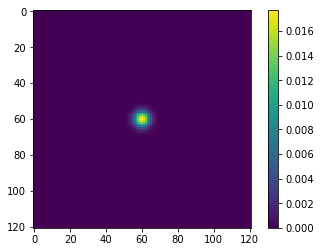

In [60]:
probs = [np.exp(-z*z/(2*3*3))/np.sqrt(2*np.pi*3*3) for z in range(-60,61)] 
kernel = np.outer(probs, probs)
plt.imshow(kernel)
plt.colorbar();

## Assignment 5: Back to space [2 pts]
Right now the picture and the filters are both in frequency domain. Let's bring them back to the spatial domain. For this, you can use an inverse fourier transform function (I know, we computed fourier transform of the picture for nothing). 
- Compute the inverse fourier transform for both the image and the kernel.
- Compute power spectrum of these.

In [61]:
# compute ifft and then the power spectrum of the image and the filter
im_ifft = fftpack.ifft2(im_fft)
ps_im = np.abs(im_ifft)**2

filter_ifft = fftpack.ifft(kernel)
ps_kernel = np.abs(filter_ifft)**2

## Assignment 6: Convolution [2 pts]

To boost your intuition of convoultion in 2-d space, I recommend the following blog article.
http://www.songho.ca/dsp/convolution/convolution2d_example.html


We are almost there. Now we just have to convolve the image and the filter in spatial domain (use the computed power spectra of assignment 5 for this) and plot the picture. Do you recognise the object in the picture?

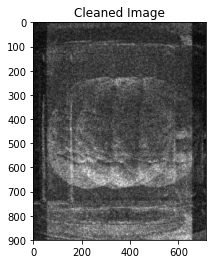

In [63]:
# compute the convolution
conv_nd = ndimage.convolve(ps_im, ps_kernel, mode='constant')

# plot the filtered image
plt.figure()
plt.imshow(conv_nd, plt.cm.gray)
plt.title('Cleaned Image');
# why are these strange edges there? Maybe the kernel is at wrong position but it actually looks pretty good

In [ ]:
# compute the convolution. There seems to be a padding issue here!
# apparently we should use ndimage.convolve anyways
conv = signal.convolve2d(ps_im, ps_kernel)

# plot the filtered image
plt.figure()
plt.imshow(conv, plt.cm.gray)
plt.title('Cleaned Image');

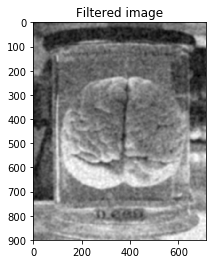

In [33]:
# the lesson here: use of the shelve functions if someone made the effort to implement them!
# This is probably how it should look like if done correctly
im_blur = ndimage.gaussian_filter(im, 4)

plt.figure()
plt.imshow(im_blur, cmap='gray')
plt.title('Filtered image');

What do you see? 

**It is a brain in a jar!**